In [1]:
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

In [2]:
# Read in data into a dataframe number of rows - 6358
file = 'soccer_player_embeddings_feature_no_labels.csv'
df = pd.read_csv('../../datasets/final_embeddings/{}'.format(file))
df.head(2)

,Unnamed: 0,player_positions,player_fifa_api_id,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,player_positions_general
0,0,CB,218353,0.378084,0.493866,-0.218586,-0.238711,-0.500447,0.219325,0.125196,-0.119898,-0.141964,0.142511,-0.056706,0.011622,0.019336,0.023303,DEF
1,1,LB,189615,-1.046989,-0.190204,1.120495,0.563388,-0.440816,-0.198932,0.338791,0.223150,0.041387,-0.025337,0.229595,0.055748,-0.099781,0.020387,DEF


# Functions for DBScan

In [17]:
def kth_neighbour(k, X, metric='euclidean'):
    neigh = NearestNeighbors(n_neighbors=k, metric=metric)
    neigh.fit(X)
    dist, ind = neigh.kneighbors(X)
    distances = sorted([dist[i][k - 1] for i in range(len(dist))])

    return distances


def plot_kdist(dist, idx):
    plt.figure(figsize =(7, 5))
    plt.plot(dist)
    plt.axvline(x=idx, color='r', linestyle='dashed')
    plt.axhline(y=dist[idx], color='r', linestyle='dashed')
    plt.ylabel("k-distances (eps)")
    plt.title('K-distance Graph')
    plt.grid(True)
    plt.savefig('k_distance_graph.png')
    plt.show()
    
def find_eps(dist):
    sec_drv = np.diff(dist, 2)
    start, end = 100, -300
    idx = np.argmax(sec_drv[start:end]) + start
    eps = dist[idx]
#     print('start = {}, end = {}'.format(start, end))
    print('eps_idx = {}, eps = {}'.format(idx, eps))
    return idx, eps

def try_dbscan(samples, eps, min_pts, metric='euclidean'):
    # Based on graph above, use eps = 0.9
    db = DBSCAN(eps=eps, min_samples=min_pts, metric=metric).fit(samples)
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    db_labels = db.labels_

    n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
    n_noise_ = list(db_labels).count(-1)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, db_labels))
    
    # Black removed and is used for noise instead.
    plt.figure(figsize =(5, 5)) 
    unique_labels = set(db_labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (db_labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    return db.labels_, n_clusters_

# Prepare data for DBScan

In [18]:
# Get X and Y datasets
y = df['player_positions']
X = df.drop(columns=['Unnamed: 0', 'player_positions', 'player_fifa_api_id',
                     'player_positions_general', 'player_positions_list'])

labels = []
for l in y.values:
    if ',' in l:
        labels.extend(l.split(", "))
    else:
        labels.append(l)

labels, counts = np.unique(labels, return_counts=True)

eps_idx = 6043, eps = 0.8405484171913807


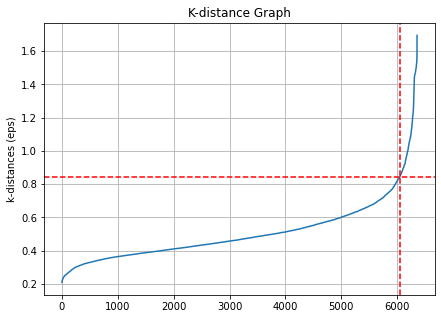

In [19]:
# mp: minPoints - taken as twice of the number of features
mp = len(X.columns) * 2

# Calculate the distance of the kth neighbour where k = mp
dist = kth_neighbour(mp, X)

# Find epsilon(eps) from the kth neighbour dist results
idx, eps = find_eps(dist)

# Visualise the eps chosen on graph to do a visual check
plot_kdist(dist, idx)